<a href="https://colab.research.google.com/github/Sabila97/Detection-of-Multiple-Sclerosis-using-Deep-Learning/blob/main/multiplesclerosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imutils
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
from tensorflow.keras.models import load_model
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [ ]:
dataset="/Users/17101129/Downloads/dataset/train_images"
imagePaths = list(paths.list_images(dataset))
#print(imagePaths)
data = []
labels = []
#img_rows, img_cols = 200, 200

# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
data = np.array(data) / 255.0
labels = np.array(labels)

In [ ]:
print("...Number of images we have got: "+str(len(data)))
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
#labels = to_categorical(labels)

...Number of images we have got: 3766


In [ ]:
labels

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

In [ ]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.25, stratify=labels, random_state=42,shuffle=True)

# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest")

In [ ]:
valAug = ImageDataGenerator()

# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [ ]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
                  input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(30, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(4, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 20
BS = 2

In [ ]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

[INFO] compiling model...


In [ ]:

# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...


C:\Users\17101129\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
1412/1412 [==============================] - 406s 286ms/step - loss: 0.9716 - accuracy: 0.6470 - val_loss: 0.6283 - val_accuracy: 0.7739
Epoch 2/20
1412/1412 [==============================] - 407s 288ms/step - loss: 0.6364 - accuracy: 0.7518 - val_loss: 0.4871 - val_accuracy: 0.8238
Epoch 3/20
1412/1412 [==============================] - 403s 286ms/step - loss: 0.4573 - accuracy: 0.8336 - val_loss: 0.3442 - val_accuracy: 0.8747
Epoch 4/20
1412/1412 [==============================] - 403s 285ms/step - loss: 0.3241 - accuracy: 0.8803 - val_loss: 0.2025 - val_accuracy: 0.9299
Epoch 5/20
1412/1412 [==============================] - 403s 285ms/step - loss: 0.2530 - accuracy: 0.8991 - val_loss: 0.1680 - val_accuracy: 0.9374
Epoch 6/20
1412/1412 [==============================] - 406s 288ms/step - loss: 0.2167 - accuracy: 0.9231 - val_loss: 0.1244 - val_accuracy: 0.9586
Epoch 7/20
1412/1412 [==============================] - 404s 286ms/step - loss: 0.1769 - accuracy: 0.9346 - val_

[INFO] evaluating network...
              precision    recall  f1-score   support

         CIS       1.00      0.92      0.96       126
          PR       1.00      0.88      0.93        73
          RR       0.97      1.00      0.98       621
          SP       1.00      0.99      1.00       122

    accuracy                           0.98       942
   macro avg       0.99      0.95      0.97       942
weighted avg       0.98      0.98      0.98       942

[[116   0  10   0]
 [  0  64   9   0]
 [  0   0 621   0]
 [  0   0   1 121]]
accuracy: 0.9788


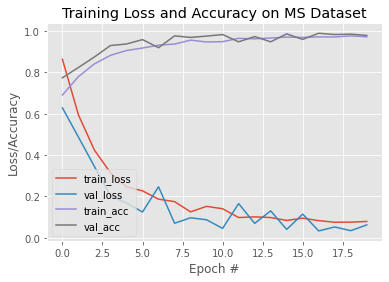

In [ ]:

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]+cm[2,2]+cm[3,3]) / total

# show the confusion matrix, accuracy
print(cm)
print("accuracy: {:.4f}".format(acc))


# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on MS Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('./training loss and accuracy curve.jpg')

# serialize the model to disk

model.save("/Users/17101129/Downloads/dataset/modelv1.h5", save_format="h5")

In [ ]:
dataset="/Users/17101129/Downloads/dataset/test_images"
imagePaths = list(paths.list_images(dataset))
data = []
labels = []


# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
data = np.array(data) / 255.0
labels = np.array(labels)

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [ ]:
predIdxs = model.predict(data, batch_size=2)
predIdxs = np.argmax(predIdxs, axis=1)

In [ ]:
print(classification_report(labels.argmax(axis=1), predIdxs,target_names=lb.classes_))
cm = confusion_matrix(labels.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]+cm[2,2]+cm[3,3]) / total

# show the confusion matrix, accuracy
print(cm)
print("accuracy: {:.4f}".format(acc))

              precision    recall  f1-score   support

         CIS       0.86      1.00      0.92         6
          PR       1.00      0.67      0.80         6
          RR       0.97      0.98      0.98        60
          SP       1.00      1.00      1.00         5

    accuracy                           0.96        77
   macro avg       0.96      0.91      0.92        77
weighted avg       0.96      0.96      0.96        77

[[ 6  0  0  0]
 [ 0  4  2  0]
 [ 1  0 59  0]
 [ 0  0  0  5]]
accuracy: 0.9610
